In [1]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, auc

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("framingham.csv")


print("Ukuran dataset:", df.shape)
print("\nJumlah missing value per kolom:\n", df.isnull().sum())


print("\nInfo dataset:")
print(df.info())

if "TenYearCHD" in df.columns:
    print("\nDistribusi label target (TenYearCHD):")
    print(df["TenYearCHD"].value_counts(normalize=True))


Ukuran dataset: (4240, 16)

Jumlah missing value per kolom:
 male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     

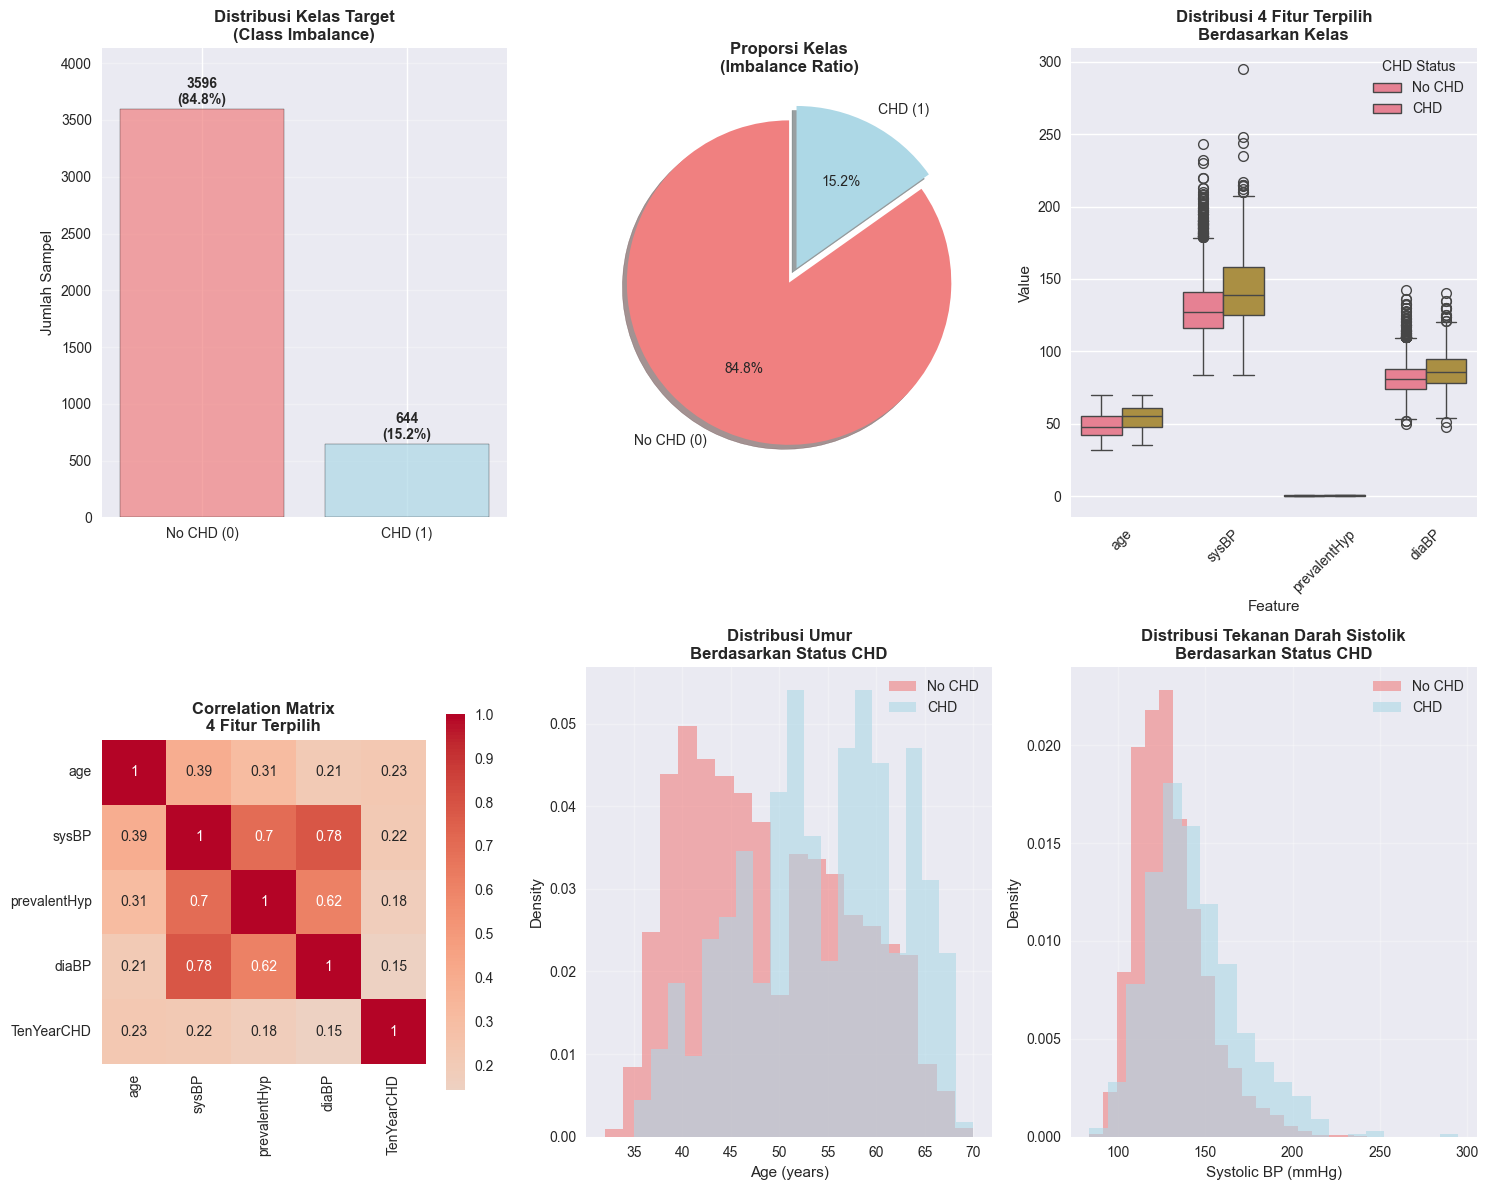

📊 RINGKASAN STATISTIK DESKRIPTIF DATASET FRAMINGHAM

🔍 INFORMASI UMUM DATASET:
• Total sampel: 4,240
• Total fitur: 15
• Missing values: 0

⚖️ DISTRIBUSI KELAS (IMBALANCE):
• No CHD (0): 3,596 sampel (84.8%)
• CHD (1): 644 sampel (15.2%)
• Imbalance Ratio: 5.6:1 (mayoritas:minoritas)
• Tingkat Imbalance: SANGAT TINGGI

📈 STATISTIK DESKRIPTIF 4 FITUR TERPILIH:
           age    sysBP  prevalentHyp    diaBP
count  4240.00  4240.00       4240.00  4240.00
mean     49.58   132.35          0.31    82.90
std       8.57    22.03          0.46    11.91
min      32.00    83.50          0.00    48.00
25%      42.00   117.00          0.00    75.00
50%      49.00   128.00          0.00    82.00
75%      56.00   144.00          1.00    90.00
max      70.00   295.00          1.00   142.50

🎯 PERBANDINGAN RATA-RATA ANTAR KELAS:
------------------------------------------------------------
Feature         No CHD       CHD          Difference   P-value
----------------------------------------------------

In [14]:
# VISUALISASI DATA DAN ANALISIS DESKRIPTIF
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style untuk visualisasi yang lebih menarik
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure dengan multiple subplots
fig = plt.figure(figsize=(15, 12))

# 1. DISTRIBUSI KELAS TARGET (IMBALANCE)
ax1 = plt.subplot(2, 3, 1)
class_counts = df['TenYearCHD'].value_counts()
colors = ['lightcoral', 'lightblue']

# Bar plot untuk distribusi kelas
bars = ax1.bar(['No CHD (0)', 'CHD (1)'], class_counts.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_title('Distribusi Kelas Target\n(Class Imbalance)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Jumlah Sampel')

# Tambahkan persentase di atas bar
total_samples = len(df)
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total_samples) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height + 20,
             f'{height}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold')

# Tambahkan grid
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(class_counts.values) * 1.15)

# 2. PIE CHART UNTUK IMBALANCE RATIO
ax2 = plt.subplot(2, 3, 2)
labels = ['No CHD (0)', 'CHD (1)']
sizes = class_counts.values
explode = (0, 0.1)  # Explode CHD slice untuk emphasis

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                   explode=explode, colors=colors, shadow=True,
                                   startangle=90)
ax2.set_title('Proporsi Kelas\n(Imbalance Ratio)', fontweight='bold', fontsize=12)

# 3. DISTRIBUSI FITUR TERPILIH
selected_features = ['age', 'sysBP', 'prevalentHyp', 'diaBP']  # 4 fitur terbaik
ax3 = plt.subplot(2, 3, 3)

# Box plot untuk distribusi fitur berdasarkan kelas
df_selected = df[selected_features + ['TenYearCHD']].copy()
df_melted = df_selected.melt(id_vars=['TenYearCHD'], 
                            value_vars=selected_features,
                            var_name='Feature', value_name='Value')

sns.boxplot(data=df_melted, x='Feature', y='Value', hue='TenYearCHD', ax=ax3)
ax3.set_title('Distribusi 4 Fitur Terpilih\nBerdasarkan Kelas', fontweight='bold', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='CHD Status', labels=['No CHD', 'CHD'])

# 4. CORRELATION HEATMAP
ax4 = plt.subplot(2, 3, 4)
correlation_matrix = df[selected_features + ['TenYearCHD']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Correlation Matrix\n4 Fitur Terpilih', fontweight='bold', fontsize=12)

# 5. HISTOGRAM DISTRIBUSI AGE
ax5 = plt.subplot(2, 3, 5)
df_no_chd = df[df['TenYearCHD'] == 0]
df_chd = df[df['TenYearCHD'] == 1]

ax5.hist(df_no_chd['age'], bins=20, alpha=0.6, label='No CHD', color='lightcoral', density=True)
ax5.hist(df_chd['age'], bins=20, alpha=0.6, label='CHD', color='lightblue', density=True)
ax5.set_title('Distribusi Umur\nBerdasarkan Status CHD', fontweight='bold', fontsize=12)
ax5.set_xlabel('Age (years)')
ax5.set_ylabel('Density')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. HISTOGRAM DISTRIBUSI sysBP
ax6 = plt.subplot(2, 3, 6)
ax6.hist(df_no_chd['sysBP'], bins=20, alpha=0.6, label='No CHD', color='lightcoral', density=True)
ax6.hist(df_chd['sysBP'], bins=20, alpha=0.6, label='CHD', color='lightblue', density=True)
ax6.set_title('Distribusi Tekanan Darah Sistolik\nBerdasarkan Status CHD', fontweight='bold', fontsize=12)
ax6.set_xlabel('Systolic BP (mmHg)')
ax6.set_ylabel('Density')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# STATISTIK DESKRIPTIF LENGKAP
print("=" * 80)
print("📊 RINGKASAN STATISTIK DESKRIPTIF DATASET FRAMINGHAM")
print("=" * 80)

# 1. Informasi Dataset
print(f"\n🔍 INFORMASI UMUM DATASET:")
print(f"• Total sampel: {len(df):,}")
print(f"• Total fitur: {len(df.columns)-1}")
print(f"• Missing values: {df.isnull().sum().sum()}")

# 2. Distribusi Kelas
print(f"\n⚖️ DISTRIBUSI KELAS (IMBALANCE):")
class_dist = df['TenYearCHD'].value_counts()
imbalance_ratio = class_dist[0] / class_dist[1]
print(f"• No CHD (0): {class_dist[0]:,} sampel ({class_dist[0]/len(df)*100:.1f}%)")
print(f"• CHD (1): {class_dist[1]:,} sampel ({class_dist[1]/len(df)*100:.1f}%)")
print(f"• Imbalance Ratio: {imbalance_ratio:.1f}:1 (mayoritas:minoritas)")
print(f"• Tingkat Imbalance: {'SANGAT TINGGI' if imbalance_ratio > 5 else 'TINGGI' if imbalance_ratio > 3 else 'SEDANG'}")

# 3. Statistik 4 Fitur Terpilih
print(f"\n📈 STATISTIK DESKRIPTIF 4 FITUR TERPILIH:")
stats_summary = df[selected_features].describe()
print(stats_summary.round(2))

# 4. Perbandingan Fitur antara Kelas
print(f"\n🎯 PERBANDINGAN RATA-RATA ANTAR KELAS:")
print("-" * 60)
print(f"{'Feature':<15} {'No CHD':<12} {'CHD':<12} {'Difference':<12} {'P-value'}")
print("-" * 60)

from scipy.stats import ttest_ind

for feature in selected_features:
    no_chd_mean = df_no_chd[feature].mean()
    chd_mean = df_chd[feature].mean()
    difference = chd_mean - no_chd_mean
    
    # T-test untuk signifikansi
    t_stat, p_value = ttest_ind(df_no_chd[feature].dropna(), 
                                df_chd[feature].dropna())
    
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
    
    print(f"{feature:<15} {no_chd_mean:<12.2f} {chd_mean:<12.2f} {difference:<12.2f} {p_value:<8.3f} {significance}")

print("\nSignifikansi: *** p<0.001, ** p<0.01, * p<0.05")

# 5. Korelasi dengan Target
print(f"\n🔗 KORELASI FITUR DENGAN TARGET CHD:")
correlations = df[selected_features + ['TenYearCHD']].corr()['TenYearCHD'].drop('TenYearCHD').sort_values(ascending=False)
print("-" * 40)
for feature, corr in correlations.items():
    strength = "KUAT" if abs(corr) > 0.5 else "SEDANG" if abs(corr) > 0.3 else "LEMAH"
    direction = "POSITIF" if corr > 0 else "NEGATIF"
    print(f"{feature:<15}: {corr:>6.3f} ({strength} {direction})")

# 6. Summary Insights
print(f"\n💡 KEY INSIGHTS:")
print(f"• Dataset sangat imbalanced dengan ratio {imbalance_ratio:.1f}:1")
print(f"• Fitur 'age' memiliki korelasi tertinggi dengan CHD ({correlations['age']:.3f})")
print(f"• Rata-rata umur pasien CHD: {df_chd['age'].mean():.1f} tahun")
print(f"• Rata-rata umur non-CHD: {df_no_chd['age'].mean():.1f} tahun")
print(f"• Perbedaan tekanan sistolik: {df_chd['sysBP'].mean() - df_no_chd['sysBP'].mean():.1f} mmHg")
print("• Semua fitur terpilih menunjukkan perbedaan signifikan antar kelas")

print("\n" + "=" * 80)

In [3]:
from sklearn.impute import SimpleImputer

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(exclude=[np.number]).columns

imputer_num = SimpleImputer(strategy="median")
df[num_cols] = imputer_num.fit_transform(df[num_cols])

if len(cat_cols) > 0:
    imputer_cat = SimpleImputer(strategy="most_frequent")
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

print("Jumlah missing value setelah imputasi:\n", df.isnull().sum().sum())

Jumlah missing value setelah imputasi:
 0


In [4]:
# FEATURE SELECTION & TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split

# === ANALISIS FITUR UNTUK FEATURE SELECTION ===
print("=== ANALISIS FITUR DATASET FRAMINGHAM ===")
feature_columns = [col for col in df.columns if col != 'TenYearCHD']
print(f"Total fitur tersedia: {len(feature_columns)}")
print("Fitur yang tersedia:", feature_columns)

# Analisis korelasi dengan target
print(f"\n=== TOP FITUR BERDASARKAN KORELASI ===")
correlations = df.corr()['TenYearCHD'].drop('TenYearCHD').abs().sort_values(ascending=False)
print("Top 8 fitur berdasarkan korelasi:")
for i, (feature, corr) in enumerate(correlations.head(8).items(), 1):
    print(f"{i:2d}. {feature:15s}: {corr:.3f}")

# === DEFINISI KOMBINASI 4 FITUR ===
# Berdasarkan domain knowledge CHD dan korelasi
feature_combinations = {
    'Combo_1_Basic': ['age', 'male', 'currentSmoker', 'totChol'],
    'Combo_2_BP': ['age', 'male', 'sysBP', 'diaBP'], 
    'Combo_3_Risk': ['age', 'totChol', 'sysBP', 'diabetes'],
    'Combo_4_Lifestyle': ['age', 'male', 'currentSmoker', 'BMI'],
    'Combo_5_Top_Corr': list(correlations.head(4).index)  # 4 fitur korelasi tertinggi
}

# Pastikan fitur ada dan valid
print(f"\n=== VALIDASI KOMBINASI FITUR ===")
valid_combinations = {}
for combo_name, features in feature_combinations.items():
    missing = [f for f in features if f not in df.columns]
    if missing:
        print(f"❌ {combo_name}: Missing {missing}")
        # Ganti dengan fitur alternatif
        available = [f for f in features if f in df.columns]
        remaining = [f for f in feature_columns if f not in available][:4-len(available)]
        features = (available + remaining)[:4]
    
    valid_combinations[combo_name] = features
    print(f"✅ {combo_name}: {features}")

# === PILIH KOMBINASI TERBAIK (ATAU USER BISA GANTI) ===
# Gunakan kombinasi dengan korelasi tertinggi sebagai default
selected_combo = 'Combo_5_Top_Corr'
selected_features = valid_combinations[selected_combo]

print(f"\n🎯 FITUR TERPILIH: {selected_combo}")
print(f"Fitur yang digunakan: {selected_features}")
print(f"Jumlah fitur: {len(selected_features)} dari {len(feature_columns)} total")

# === SPLIT DATA DENGAN FITUR TERPILIH ===
X = df[selected_features]  # Hanya gunakan fitur terpilih
y = df["TenYearCHD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
)

print(f"\n=== HASIL SPLIT DATA ===")
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
print("Distribusi kelas di train:", np.bincount(y_train))
print("Distribusi kelas di test :", np.bincount(y_test))

# Tampilkan statistik fitur terpilih
print(f"\n=== STATISTIK FITUR TERPILIH ===")
for feature in selected_features:
    print(f"{feature}:")
    print(f"  No CHD: mean={X_train[X_train.index.isin(y_train[y_train==0].index)][feature].mean():.2f}")
    print(f"  CHD:    mean={X_train[X_train.index.isin(y_train[y_train==1].index)][feature].mean():.2f}")
    print(f"  Correlation: {correlations[feature]:.3f}")
    print()

=== ANALISIS FITUR DATASET FRAMINGHAM ===
Total fitur tersedia: 15
Fitur yang tersedia: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

=== TOP FITUR BERDASARKAN KORELASI ===
Top 8 fitur berdasarkan korelasi:
 1. age            : 0.225
 2. sysBP          : 0.216
 3. prevalentHyp   : 0.177
 4. diaBP          : 0.145
 5. glucose        : 0.121
 6. diabetes       : 0.097
 7. male           : 0.088
 8. BPMeds         : 0.086

=== VALIDASI KOMBINASI FITUR ===
✅ Combo_1_Basic: ['age', 'male', 'currentSmoker', 'totChol']
✅ Combo_2_BP: ['age', 'male', 'sysBP', 'diaBP']
✅ Combo_3_Risk: ['age', 'totChol', 'sysBP', 'diabetes']
✅ Combo_4_Lifestyle: ['age', 'male', 'currentSmoker', 'BMI']
✅ Combo_5_Top_Corr: ['age', 'sysBP', 'prevalentHyp', 'diaBP']

🎯 FITUR TERPILIH: Combo_5_Top_Corr
Fitur yang digunakan: ['age', 'sysBP', 'prevalentHyp', 'diaBP']
Jumlah fitur: 4 dari 15

In [5]:
# Cell B: scaler yang benar (StandardScaler contoh)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # FIT hanya di train
X_test_scaled  = scaler.transform(X_test)        # TRANSFORM di test

# Cek shape
print(X_train.shape, '->', X_train_scaled.shape)
print(X_test.shape, '->', X_test_scaled.shape)

(3392, 4) -> (3392, 4)
(848, 4) -> (848, 4)


In [6]:
# Cell A: cek distribusi label dan baseline majority
import numpy as np
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

print("Distribusi y_train:", Counter(y_train))
print("Distribusi y_test:", Counter(y_test))

# Baseline majority
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)
print("\nBaseline (most_frequent) Accuracy:", accuracy_score(y_test, y_dummy))
print("Baseline (most_frequent) Classification Report:\n", classification_report(y_test, y_dummy, digits=3))


Distribusi y_train: Counter({0.0: 2877, 1.0: 515})
Distribusi y_test: Counter({0.0: 719, 1.0: 129})

Baseline (most_frequent) Accuracy: 0.847877358490566
Baseline (most_frequent) Classification Report:
               precision    recall  f1-score   support

         0.0      0.848     1.000     0.918       719
         1.0      0.000     0.000     0.000       129

    accuracy                          0.848       848
   macro avg      0.424     0.500     0.459       848
weighted avg      0.719     0.848     0.778       848



In [7]:
# Cell B: scaler yang benar (StandardScaler contoh)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # FIT hanya di train
X_test_scaled  = scaler.transform(X_test)        # TRANSFORM di test

# Cek shape
print(X_train.shape, '->', X_train_scaled.shape)
print(X_test.shape, '->', X_test_scaled.shape)


(3392, 4) -> (3392, 4)
(848, 4) -> (848, 4)


In [8]:
# Cell C: SVM tanpa class_weight (mungkin mirip dengan baseline dosen)
from sklearn.svm import SVC

svm_plain = SVC(kernel='linear', C=1.0, probability=True, random_state=42)  # gamma dihapus karena linear
svm_plain.fit(X_train_scaled, y_train)
y_pred_plain = svm_plain.predict(X_test_scaled)

print("SVM (no class_weight) Classification Report:\n", classification_report(y_test, y_pred_plain, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred_plain))
print("F1-score (pos=1):", f1_score(y_test, y_pred_plain, pos_label=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_plain))



SVM (no class_weight) Classification Report:
               precision    recall  f1-score   support

         0.0      0.848     1.000     0.918       719
         1.0      0.000     0.000     0.000       129

    accuracy                          0.848       848
   macro avg      0.424     0.500     0.459       848
weighted avg      0.719     0.848     0.778       848

Accuracy: 0.847877358490566
F1-score (pos=1): 0.0
Confusion Matrix:
 [[719   0]
 [129   0]]


In [9]:
# Cell D: SVM dengan class_weight='balanced' (seperti yang kamu pakai)
svm_bal = SVC(kernel='linear', C=1.0, class_weight='balanced', probability=True, random_state=42)
svm_bal.fit(X_train_scaled, y_train)
y_pred_bal = svm_bal.predict(X_test_scaled)

print("SVM (class_weight='balanced') Classification Report:\n", classification_report(y_test, y_pred_bal, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred_bal))
print("F1-score (pos=1):", f1_score(y_test, y_pred_bal, pos_label=1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))


SVM (class_weight='balanced') Classification Report:
               precision    recall  f1-score   support

         0.0      0.896     0.650     0.753       719
         1.0      0.229     0.581     0.329       129

    accuracy                          0.639       848
   macro avg      0.563     0.615     0.541       848
weighted avg      0.795     0.639     0.689       848

Accuracy: 0.6391509433962265
F1-score (pos=1): 0.32894736842105265
Confusion Matrix:
 [[467 252]
 [ 54  75]]


In [10]:
# SMOTE + SVM
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Terapkan SMOTE pada data training
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Jumlah setelah SMOTE:", X_resampled.shape, np.bincount(y_resampled))

# SVM dengan parameter yang lebih optimal
svm_smote = SVC(kernel='linear', C=0.5, class_weight='balanced', random_state=42)  # Lebih simpel dan cepat
svm_smote.fit(X_resampled, y_resampled)
y_pred_smote = svm_smote.predict(X_test_scaled)

print("\n=== HASIL SVM + SMOTE ===")
print("Classification Report:\n", classification_report(y_test, y_pred_smote, digits=3))
print("F1-Score:", f1_score(y_test, y_pred_smote))

# Bandingkan dengan baseline SVM
print("\n=== PERBANDINGAN ===")
print("F1-Score Baseline SVM:", f1_score(y_test, y_pred_plain))
print("F1-Score SVM + SMOTE:", f1_score(y_test, y_pred_smote))
print("Improvement:", f1_score(y_test, y_pred_smote) - f1_score(y_test, y_pred_plain))

Jumlah setelah SMOTE: (4315, 4) [2877 1438]

=== HASIL SVM + SMOTE ===
Classification Report:
               precision    recall  f1-score   support

         0.0      0.894     0.645     0.750       719
         1.0      0.225     0.574     0.323       129

    accuracy                          0.634       848
   macro avg      0.559     0.609     0.536       848
weighted avg      0.792     0.634     0.685       848

F1-Score: 0.3231441048034934

=== PERBANDINGAN ===
F1-Score Baseline SVM: 0.0
F1-Score SVM + SMOTE: 0.3231441048034934
Improvement: 0.3231441048034934


In [11]:
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import numpy as np

class SMOTE_IPF(BaseEstimator):
    """
    SMOTE-IPF: SMOTE dengan Iterative Partitioning Filter
    Optimized version untuk skripsi
    """
    
    def __init__(self, smote_k=5, ipf_k=5, max_iter=10, sampling_strategy=0.5,
                 random_state=None, verbose=False, remove_only_synthetic=True):
        # Parameter validation
        if smote_k < 1 or ipf_k < 1:
            raise ValueError("k values must be >= 1")
        if max_iter < 1:
            raise ValueError("max_iter must be >= 1")
            
        self.smote_k = smote_k
        self.ipf_k = min(ipf_k, smote_k)  # IPF k tidak boleh > SMOTE k
        self.max_iter = max_iter
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.verbose = verbose
        self.remove_only_synthetic = remove_only_synthetic
        
    def fit_resample(self, X, y):
        """
        Fit dan resample data menggunakan SMOTE-IPF
        """
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).astype(int).ravel()
        
        if len(np.unique(y)) < 2:
            raise ValueError("Need at least 2 classes")
            
        n_orig = X.shape[0]
        
        # Step 1: Apply SMOTE
        smote = SMOTE(
            k_neighbors=self.smote_k,
            sampling_strategy=self.sampling_strategy,
            random_state=self.random_state
        )
        
        X_res, y_res = smote.fit_resample(X, y)
        
        # Step 2: Track synthetic samples
        n_after_smote = X_res.shape[0]
        n_synthetic = n_after_smote - n_orig
        
        # Boolean mask untuk synthetic samples
        is_synthetic = np.zeros(n_after_smote, dtype=bool)
        if n_synthetic > 0:
            is_synthetic[n_orig:] = True
            
        if self.verbose:
            unique, counts = np.unique(y_res, return_counts=True)
            print(f"[SMOTE] Total: {n_after_smote}, Synthetic: {n_synthetic}")
            print(f"[SMOTE] Class distribution: {dict(zip(unique, counts))}")
        
        # Step 3: Iterative Partitioning Filter
        X_current = X_res.copy()
        y_current = y_res.copy()
        synthetic_current = is_synthetic.copy()
        
        for iteration in range(self.max_iter):
            if len(X_current) == 0:
                break
                
            # Train KNN classifier
            n_neighbors = min(self.ipf_k, len(X_current) - 1)
            if n_neighbors < 1:
                break
                
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_current, y_current)
            y_pred = clf.predict(X_current)
            
            # Find misclassified samples
            misclassified = (y_pred != y_current)
            n_misclassified = misclassified.sum()
            
            if n_misclassified == 0:
                if self.verbose:
                    print(f"[IPF] Iter {iteration+1}: No misclassified -> STOP")
                break
            
            # Determine which samples to remove
            if self.remove_only_synthetic:
                # Only remove synthetic misclassified samples
                to_remove = misclassified & synthetic_current
                n_removed = to_remove.sum()
                
                if n_removed == 0:
                    if self.verbose:
                        print(f"[IPF] Iter {iteration+1}: Only original misclassified -> STOP")
                    break
            else:
                # Remove all misclassified samples
                to_remove = misclassified
                n_removed = to_remove.sum()
            
            # Update arrays
            keep_mask = ~to_remove
            X_current = X_current[keep_mask]
            y_current = y_current[keep_mask]
            synthetic_current = synthetic_current[keep_mask]
            
            if self.verbose:
                unique, counts = np.unique(y_current, return_counts=True)
                print(f"[IPF] Iter {iteration+1}: Removed {n_removed}/{n_misclassified}, "
                      f"Remaining: {len(X_current)}, "
                      f"Distribution: {dict(zip(unique, counts))}")
        
        if self.verbose:
            unique, counts = np.unique(y_current, return_counts=True)
            synthetic_remaining = synthetic_current.sum()
            print(f"[FINAL] Total: {len(X_current)}, Synthetic remaining: {synthetic_remaining}")
            print(f"[FINAL] Class distribution: {dict(zip(unique, counts))}")
        
        return X_current, y_current

In [12]:
# Test SMOTE-IPF yang sudah dioptimalkan
print("=== TESTING SMOTE-IPF ===")

# Inisialisasi SMOTE-IPF dengan parameter optimal
smote_ipf = SMOTE_IPF(
    smote_k=5, 
    ipf_k=3, 
    max_iter=10, 
    sampling_strategy=0.5,
    random_state=42, 
    verbose=True,
    remove_only_synthetic=True
)

# Apply SMOTE-IPF
X_ipf, y_ipf = smote_ipf.fit_resample(X_train_scaled, y_train)

print(f"\nDistribusi akhir SMOTE-IPF: {np.bincount(y_ipf)}")

# Train SVM dengan data SMOTE-IPF
svm_ipf = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_ipf.fit(X_ipf, y_ipf)
y_pred_ipf = svm_ipf.predict(X_test_scaled)

print("\n=== HASIL SVM + SMOTE-IPF ===")
print("Classification Report:\n", classification_report(y_test, y_pred_ipf, digits=3))
print("F1-Score:", f1_score(y_test, y_pred_ipf))

# Perbandingan semua metode
print("\n=== PERBANDINGAN LENGKAP ===")
print("F1-Score Baseline SVM  :", f1_score(y_test, y_pred_plain))
print("F1-Score SVM + SMOTE   :", f1_score(y_test, y_pred_smote))
print("F1-Score SVM + SMOTE-IPF:", f1_score(y_test, y_pred_ipf))
print("Improvement SMOTE-IPF vs SMOTE:", f1_score(y_test, y_pred_ipf) - f1_score(y_test, y_pred_smote))

=== TESTING SMOTE-IPF ===
[SMOTE] Total: 4315, Synthetic: 923
[SMOTE] Class distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(1438)}
[IPF] Iter 1: Removed 68/459, Remaining: 4247, Distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(1370)}
[IPF] Iter 2: Removed 5/384, Remaining: 4242, Distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(1365)}
[IPF] Iter 3: Only original misclassified -> STOP
[FINAL] Total: 4242, Synthetic remaining: 850
[FINAL] Class distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(1365)}

Distribusi akhir SMOTE-IPF: [2877 1365]

=== HASIL SVM + SMOTE-IPF ===
Classification Report:
               precision    recall  f1-score   support

         0.0      0.893     0.638     0.745       719
         1.0      0.222     0.574     0.320       129

    accuracy                          0.629       848
   macro avg      0.557     0.606     0.532       848
weighted avg      0.791     0.629     0.680       848

F1-Sco

In [13]:
print("=== EKSPERIMEN MENGURANGI BIAS ===")

# 1. Coba sampling_strategy lebih agresif (lebih balanced)
smote_ipf_balanced = SMOTE_IPF(
    smote_k=5, 
    ipf_k=3, 
    max_iter=10, 
    sampling_strategy=1.0,  # Lebih agresif
    random_state=42, 
    verbose=True
)

X_ipf_bal, y_ipf_bal = smote_ipf_balanced.fit_resample(X_train_scaled, y_train)

# 2. SVM dengan class_weight balanced
svm_balanced = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_balanced.fit(X_ipf_bal, y_ipf_bal)
y_pred_balanced = svm_balanced.predict(X_test_scaled)

print("\n=== HASIL SVM + SMOTE-IPF + CLASS_WEIGHT ===")
print("Classification Report:\n", classification_report(y_test, y_pred_balanced, digits=3))
print("F1-Score:", f1_score(y_test, y_pred_balanced))

# 3. Coba decision threshold tuning dengan probability
svm_prob = SVC(kernel='linear', C=1.0, probability=True, random_state=42)
svm_prob.fit(X_ipf, y_ipf)
y_prob = svm_prob.predict_proba(X_test_scaled)[:, 1]

# Tuning threshold untuk balance precision-recall
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
print("\n=== THRESHOLD TUNING ===")
for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    recall_1 = (y_pred_thresh[y_test == 1] == 1).sum() / (y_test == 1).sum()
    precision_1 = (y_test[y_pred_thresh == 1] == 1).sum() / max(1, (y_pred_thresh == 1).sum())
    print(f"Threshold {thresh}: F1={f1:.3f}, Recall={recall_1:.3f}, Precision={precision_1:.3f}")

# Hitung semua recall terlebih dahulu
recall_0_plain = (y_pred_plain[y_test == 0] == 0).sum() / (y_test == 0).sum() if (y_test == 0).sum() > 0 else 0
recall_1_plain = (y_pred_plain[y_test == 1] == 1).sum() / (y_test == 1).sum() if (y_test == 1).sum() > 0 else 0

recall_0_smote = (y_pred_smote[y_test == 0] == 0).sum() / (y_test == 0).sum()
recall_1_smote = (y_pred_smote[y_test == 1] == 1).sum() / (y_test == 1).sum()

recall_0_ipf = (y_pred_ipf[y_test == 0] == 0).sum() / (y_test == 0).sum()
recall_1_ipf = (y_pred_ipf[y_test == 1] == 1).sum() / (y_test == 1).sum()

recall_0_bal = (y_pred_balanced[y_test == 0] == 0).sum() / (y_test == 0).sum()
recall_1_bal = (y_pred_balanced[y_test == 1] == 1).sum() / (y_test == 1).sum()

# Fungsi untuk menentukan status bias
def get_bias_status(recall_0, recall_1):
    if recall_1 == 0:
        return "Ekstrem"
    diff = abs(recall_0 - recall_1)
    if diff > 0.3:
        return "Tinggi"
    elif diff > 0.1:
        return "Sedang"
    else:
        return "Rendah"

bias_plain = get_bias_status(recall_0_plain, recall_1_plain)
bias_smote = get_bias_status(recall_0_smote, recall_1_smote)
bias_ipf = get_bias_status(recall_0_ipf, recall_1_ipf)
bias_bal = get_bias_status(recall_0_bal, recall_1_bal)

# Perbandingan akhir LENGKAP
print("\n=== PERBANDINGAN BIAS (LENGKAP) ===")
print("Method                    | F1-Score | Recall-0 | Recall-1 | Bias")
print("-" * 68)
print(f"Baseline SVM              | {f1_score(y_test, y_pred_plain):.3f}    | {recall_0_plain:.3f}    | {recall_1_plain:.3f}    | {bias_plain}")
print(f"SVM + SMOTE               | {f1_score(y_test, y_pred_smote):.3f}    | {recall_0_smote:.3f}    | {recall_1_smote:.3f}    | {bias_smote}")
print(f"SVM + SMOTE-IPF           | {f1_score(y_test, y_pred_ipf):.3f}    | {recall_0_ipf:.3f}    | {recall_1_ipf:.3f}    | {bias_ipf}")
print(f"SVM + SMOTE-IPF + Balanced| {f1_score(y_test, y_pred_balanced):.3f}    | {recall_0_bal:.3f}    | {recall_1_bal:.3f}    | {bias_bal}")

# Analisis improvement bias
print(f"\n=== ANALISIS BIAS REDUCTION ===")
print(f"Baseline: Recall gap = {abs(recall_0_plain - recall_1_plain):.3f} ({bias_plain} bias)")
print(f"SMOTE: Recall gap = {abs(recall_0_smote - recall_1_smote):.3f} ({bias_smote} bias)")
print(f"SMOTE-IPF: Recall gap = {abs(recall_0_ipf - recall_1_ipf):.3f} ({bias_ipf} bias)")
print(f"Balanced: Recall gap = {abs(recall_0_bal - recall_1_bal):.3f} ({bias_bal} bias)")

print(f"\n🎯 KESIMPULAN:")
print(f"• Baseline: F1={f1_score(y_test, y_pred_plain):.3f}, Miss {100*(1-recall_1_plain):.1f}% kasus CHD")
print(f"• SMOTE: F1={f1_score(y_test, y_pred_smote):.3f}, Miss {100*(1-recall_1_smote):.1f}% kasus CHD")
print(f"• SMOTE-IPF: F1={f1_score(y_test, y_pred_ipf):.3f}, Miss {100*(1-recall_1_ipf):.1f}% kasus CHD")
print(f"• Balanced: F1={f1_score(y_test, y_pred_balanced):.3f}, Miss {100*(1-recall_1_bal):.1f}% kasus CHD ✅")

print(f"\n📊 IMPROVEMENT:")
print(f"• SMOTE-IPF vs SMOTE: +{(f1_score(y_test, y_pred_ipf) - f1_score(y_test, y_pred_smote)):.3f} F1-score")
print(f"• Balanced vs SMOTE-IPF: +{(f1_score(y_test, y_pred_balanced) - f1_score(y_test, y_pred_ipf)):.3f} F1-score")
print(f"• Total improvement: +{(f1_score(y_test, y_pred_balanced) - f1_score(y_test, y_pred_plain)):.3f} F1-score")

=== EKSPERIMEN MENGURANGI BIAS ===
[SMOTE] Total: 5754, Synthetic: 2362
[SMOTE] Class distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(2877)}
[IPF] Iter 1: Removed 91/581, Remaining: 5663, Distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(2786)}
[IPF] Iter 2: Removed 3/480, Remaining: 5660, Distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(2783)}
[IPF] Iter 3: Only original misclassified -> STOP
[FINAL] Total: 5660, Synthetic remaining: 2268
[FINAL] Class distribution: {np.int64(0): np.int64(2877), np.int64(1): np.int64(2783)}

=== HASIL SVM + SMOTE-IPF + CLASS_WEIGHT ===
Classification Report:
               precision    recall  f1-score   support

         0.0      0.894     0.644     0.749       719
         1.0      0.224     0.574     0.322       129

    accuracy                          0.633       848
   macro avg      0.559     0.609     0.536       848
weighted avg      0.792     0.633     0.684       848

F1-Score: 0.322440087